# **Installing** **Requirements**






In [1]:
!pip install controlnet_aux

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.4/202.4 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.3 MB/s eta 0:00:00
  Created wheel for controlnet_aux: filename=controlnet_aux-0.0.7-py3-none-any.whl size=274340 sha256=e028ea734563be8cb3e6ab2b6186e4f91171594aa4f7e7441168535ee6b04a9c
  Stored in directory: /root/.cache/pip/wheels/1e/3e/93/6678b4c0bc2ec31d53409b25d4189cbb08bae843e8b2b78e52
Successfully built controlnet_aux


In [2]:
!pip install diffusers transformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 13.0 MB/s eta 0:00:00


## **ControlNet-OpenPose**

ControlNet is a neural network structure to control diffusion models by adding extra conditions. This checkpoint corresponds to the ControlNet conditioned on Human Pose Estimation.
> More information about[link text](https://) ControlNet OpenPose implementation:
https://huggingface.co/lllyasviel/sd-controlnet-openpose#controlnet---human-pose-version#

In [3]:
from PIL import Image
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler, DEISMultistepScheduler
import torch
from controlnet_aux import OpenposeDetector
from diffusers.utils import load_image
import os
import matplotlib.pyplot as plt

def grid_img(imgs, rows=1, cols=3, scale=1):
  assert len(imgs) == rows * cols

  w, h = imgs[0].size
  w, h = int(w*scale), int(h*scale)

  grid = Image.new('RGB', size=(cols*w, rows*h))
  grid_w, grid_h = grid.size

  for i, img in enumerate(imgs):
      img = img.resize((w,h), Image.ANTIALIAS)
      grid.paste(img, box=(i%cols*w, i//cols*h))
  return grid

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/controlnet_aux/segment_anything/modeling/tiny_vit_sam.py:654: UserWarning: Overwriting tiny_vit_5m_224 in registry with controlnet_aux.segment_anything.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/usr/local/lib/python3.10/dist-packages/controlnet_aux/segment_anything/modeling/tiny_vit_sam.py:654: UserWarning: Overwriting tiny_vit_11m_224 in registry with controlnet_aux.segment_anything.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.

In [4]:
openpose = OpenposeDetector.from_pretrained('lllyasviel/ControlNet')

body_pose_model.pth:   0%|          | 0.00/209M [00:00<?, ?B/s]

hand_pose_model.pth:   0%|          | 0.00/147M [00:00<?, ?B/s]

facenet.pth:   0%|          | 0.00/154M [00:00<?, ?B/s]

<ipython-input-3-16e910ecd012>:19: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((w,h), Image.ANTIALIAS)


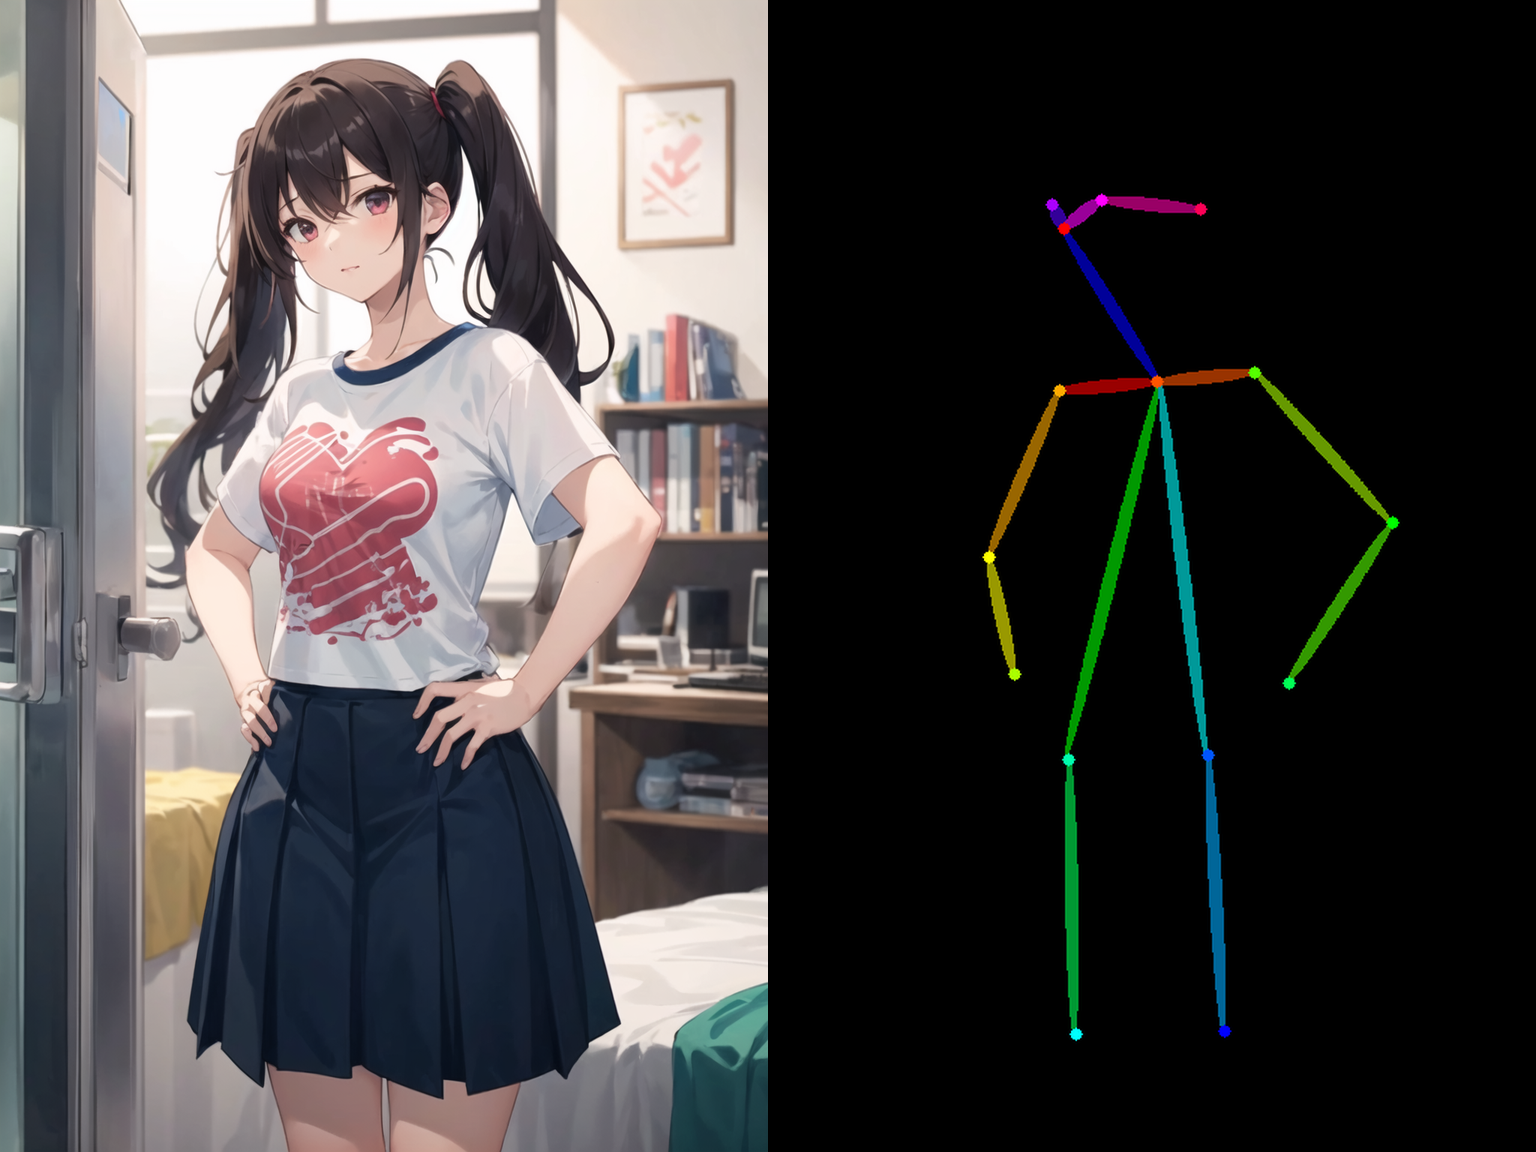

In [29]:
image_pose = load_image("/content/ref_pose_1.png") #Dont forget to upload the reference poses!!
image = openpose(image_pose)
grid_img([image_pose, image], rows=1, cols=2, scale=0.75)

# **Installing** **the** **Model**

Installing the custom model that I fine-tuned with DreamBooth. Installing the model from: https://huggingface.co/eliftansusunar/xyz

---

In [32]:
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16
)

In [33]:
pipepose = StableDiffusionControlNetPipeline.from_pretrained(
    "eliftansusunar/xyz", controlnet=controlnet, safety_checker=None, torch_dtype=torch.float16
)

vae/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


# **Constructing the Pipeline for Task2**

Two different scheduler is represented to test their impacts. Run only one of them.

Scheduler 1:

In [ ]:
pipepose.scheduler = UniPCMultistepScheduler.from_config(pipepose.scheduler.config)
pipepose.enable_model_cpu_offload()
pipepose.enable_attention_slicing()

Scheduler 2:

In [34]:
pipepose.scheduler = DEISMultistepScheduler.from_config(pipepose.scheduler.config)
pipepose.enable_model_cpu_offload()
pipepose.enable_attention_slicing()

In [37]:
negative_prompt = "ugly, tiling, poorly drawn hands, poorly drawn feet, poorly drawn face, out of frame, extra limbs, disfigured, deformed, body out of frame, bad anatomy, watermark, signature, cut off, low contrast, underexposed, overexposed, bad art, beginner, amateur, distorted face,lowres, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry"

image_chn = pipepose("xyz walking around her neighborhood", image,  negative_prompt=negative_prompt,  num_inference_steps=40).images[0]

  0%|          | 0/40 [00:00<?, ?it/s]

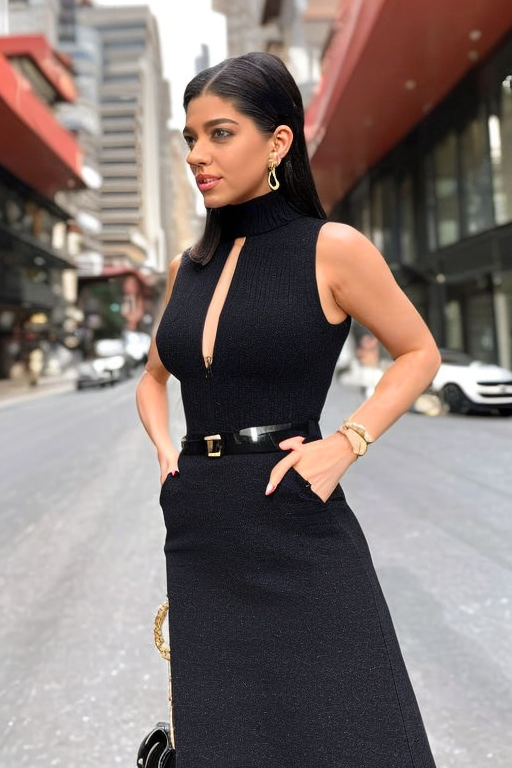

In [38]:
display(image_chn)

# **Integrating** **Upscale** **Model** **Task3**

Integrating : Super-resolution

The Stable Diffusion upscaler diffusion model was created by the researchers and engineers from CompVis, Stability AI, and LAION. It is used to enhance the resolution of input images by a factor of 4.
https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/upscale

In [39]:
from diffusers import StableDiffusionUpscalePipeline

model_id = "stabilityai/stable-diffusion-x4-upscaler"
upscaler = StableDiffusionUpscalePipeline.from_pretrained(model_id, torch_dtype=torch.float16)
upscaler = upscaler.to("cuda")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

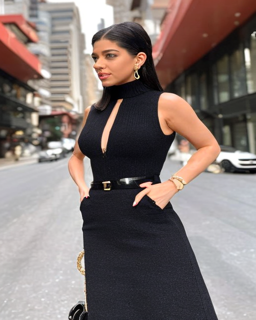

In [40]:
low_res_img = image_chn.convert("RGB")
low_res_img = low_res_img.resize((256, 320))
display(low_res_img)

In [41]:
negative_prompt = "ugly, tiling, poorly drawn hands, poorly drawn feet, poorly drawn face, out of frame, extra limbs, disfigured, deformed, body out of frame, bad anatomy, watermark, signature, cut off, low contrast, underexposed, overexposed, bad art, beginner, amateur, distorted face,lowres, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry"
prompt = "a photo of xyz in the snow, 4k, hyper realistic, extremely detailed, professional, not grainy"
upscaled_image = upscaler(prompt=prompt, image=low_res_img, negative_prompt=negative_prompt,  num_inference_steps=40).images[0]

  0%|          | 0/40 [00:00<?, ?it/s]

In [42]:
display(upscaled_image)

# **Inference (Test)**

In [27]:
import random
import torch
from torch import autocast

prompt = ["xyz walking around her neighborhood, 4k, hyper realistic, extremely detailed, professional,detailed facial features, detailed eyes",
          "photo of xyz  in the desert, closeup, pyramids in the background, natural lighting, frontal face,detailed facial features, detailed eyes",
          "photo of xyz  in the forest,detailed facial features, detailed eyes",
          "photo of xyz, highlights in hair, detailed facial features, detailed eyes, sitting outside restaurant, brown eyes, wearing a dress, side light",
          "face portrait of xyz in the snow, realistic, hd,vivid, sunset, detailed facial features, detailed eyes"]

negative_prompt = ["bad anatomy, ugly, deformed, desfigured, distorted face,distorted hand, poorly drawn hands, poorly drawn face, poorly drawn feet, blurry, low quality, low definition, lowres, out of frame, out of image, cropped, cut off, signature, watermark" ] * len(prompt)
num_samples = 1
guidance_scale = 10
num_inference_steps = 30
height = 512
width = 512

seed = random.randint(0, 2147483647)
print("Seed: {}".format(str(seed)))
generator = torch.Generator(device='cuda').manual_seed(seed)

with autocast("cuda"), torch.inference_mode():
    imgs = pipepose(
        prompt,
        image,
        guidance_scale=guidance_scale,
        negative_prompt=negative_prompt,
        num_inference_steps=num_inference_steps,
    ).images


for img in imgs:
    print("This is the image before upscaling: ")
    display(img)
    low_res_img = img.convert("RGB")
    low_res_img = low_res_img.resize((256, 320))
    #display(low_res_img)
    upscaled_image = upscaler(prompt="xyz", image=low_res_img, negative_prompt="bad anatomy, ugly, deformed, desfigured, distorted face, poorly drawn hands, poorly drawn face, poorly drawn feet, blurry, low quality, low definition, lowres, out of frame, out of image, cropped, cut off, signature, watermark",  num_inference_steps=40).images[0]
    print("These are the images after upscaling: ")
    display(upscaled_image)



Output hidden; open in https://colab.research.google.com to view.